In [34]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from pprint import pprint
from collections import Counter
import itertools  
from collections import defaultdict

%matplotlib inline

In [173]:
displayed_sq = 100
width_margin = 600
height_margin = 600



low_thresh = 15

nucleus_size_low = 250
axon_size_low = 30

first_merge_contures_thresh = 20
first_merge_centroids_thresh = 70


centroids_distance_thresh = 70
contures_distance_thresh = 20

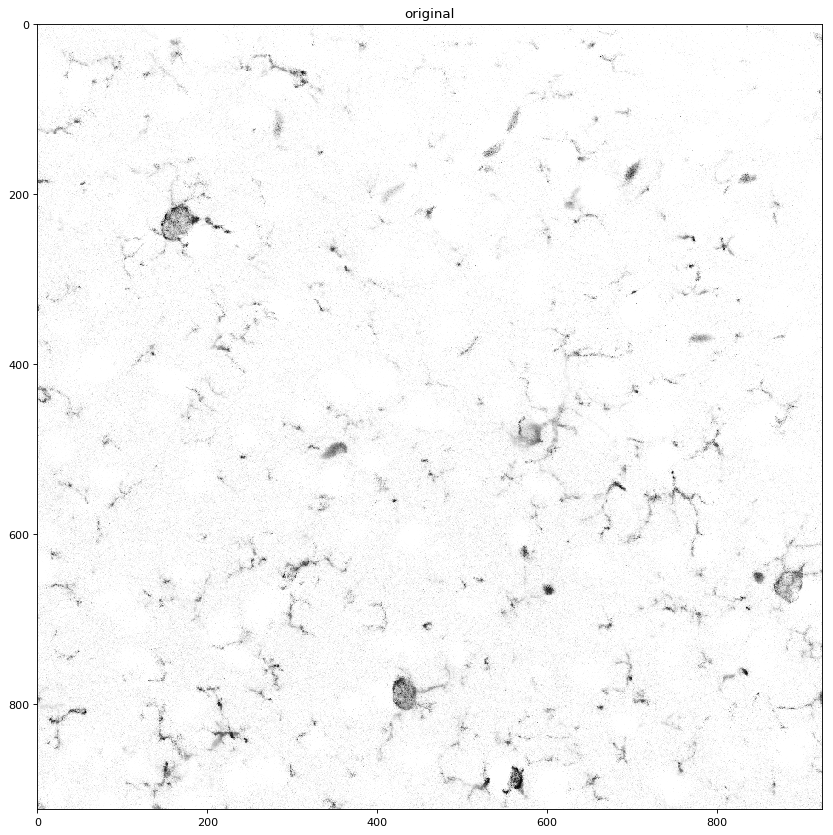

In [2]:
img = cv2.imread('raw_pics/3.bmp')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
invert = cv2.bitwise_not(gray)

fig = plt.figure(figsize=(13, 13), dpi= 80, facecolor='w', edgecolor='k')
plt.title("original")
plt.imshow(invert[height_margin:height_margin+displayed_sq,width_margin:width_margin+displayed_sq], cmap="gray")
plt.show()

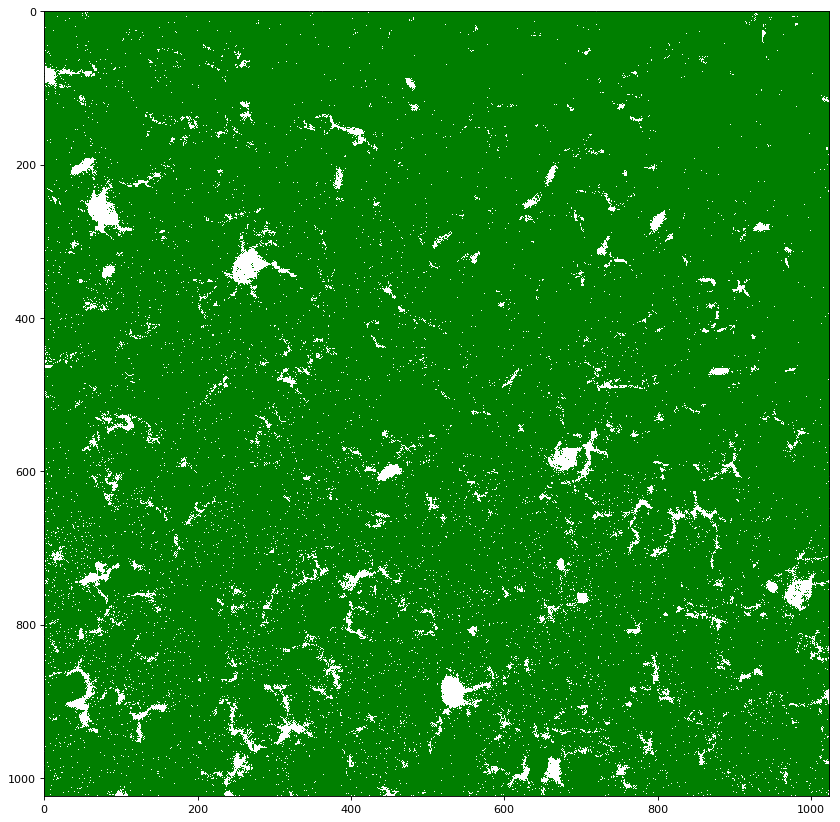

In [20]:
ret, binary = cv2.threshold(gray, low_thresh, 255, cv2.THRESH_BINARY)

#kernel = np.ones((2, 2), np.uint8)
#binary = cv2.morphologyEx(binary,cv2.MORPH_OPEN,kernel, iterations = 2)

fig = plt.figure(figsize=(13, 13), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(binary[height_margin:height_margin+displayed_sq,width_margin:width_margin+displayed_sq], cmap="ocean")

In [168]:
def get_components_info(binary):
    nbComponents, markers, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

    comp_labels, comp_map = get_components_with_stats_between(stats, centroids, axon_size_low, max(stats[:, -1]) - 1)

    add_edge_points_info_to_map(comp_map, markers)

    return connect_close_components(comp_map, markers, first_merge_centroids_thresh,
                                    first_merge_contures_thresh)
def get_nucleus_and_axons_info(comp_map, markers):
    nucl_map = dict(filter(lambda x: x[1]['size'] > nucleus_size_low, comp_map.items()))
    print(len(nucl_map))
    axons_map = dict(filter(lambda x: axon_size_low < x[1]['size'] < nucleus_size_low, comp_map.items()))
    print(len(axons_map))

    for ax in axons_map.values():
        ax['type'] = 'axon'
        ax['nucl'] = -1

    for nucl in nucl_map.values():
        conected = get_conected_axons(nucl, axons_map.values())
        for axon in conected:
            axons_map[axon["label"]]["nucl"] = nucl['label']

        nucl_map[nucl['label']]["axons"] = conected
        nucl_map[nucl['label']]["type"] = "nucl"

    return nucl_map, axons_map, markers

def get_components_with_stats_between(stats, centroids, low, high):
    components_labels = []
    components_map = {}
    for i in range(len(stats)):
        if low < stats[i, -1] < high:
            components_labels.append(i)
            components_map[i] = {
                "size": stats[i, -1],
                "centroid": centroids[i],
                "label": i}
    return components_labels, components_map


def add_edge_points_info_to_map(map, markers):
    test_pic = np.zeros(markers.shape)

    for v in map.values():
        v["edge"] = []

    for i in range(1, markers.shape[0] - 1):
        for j in range(1, markers.shape[1] - 1):
            cur_lab = markers[i, j]
            if cur_lab in map.keys() and not cur_lab == markers[i, j + 1] == markers[i, j - 1] == markers[i + 1, j] == \
                    markers[i - 1, j]:
                map[cur_lab]["edge"].append(np.array([i, j]))
                test_pic[i, j] = 1
    return test_pic


def connect_close_components(comp_map, markers, centroid_t, contur_t):
    '''
    This function updates markers and components map.
    In updated info some components would be merged into one big component. 
    '''

    labels = list(comp_map.keys())
    labels_to_merge = defaultdict(list)
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):

            if np.linalg.norm(comp_map[labels[i]]["centroid"] - comp_map[labels[j]]["centroid"]) < centroid_t:
                close, points = is_components_close(comp_map[labels[i]], comp_map[labels[j]], contur_t)
                if close:
                    labels_to_merge[labels[i]].append((labels[j], points))
    #pprint(labels_to_merge)
    comp_map, markers = update_comp_map_and_markers(comp_map, markers, labels_to_merge)

    return comp_map, markers

def update_comp_map_and_markers(comp_map, markers, labels_to_merge):
    while labels_to_merge:
        lab_id = list(labels_to_merge.keys())[0]
        markers = process_label(lab_id, labels_to_merge, comp_map, markers)
    return comp_map, markers

def process_label(lab_id, labels_to_merge, comp_map, markers):
    label_to_merge = labels_to_merge.pop(lab_id)
    for connected in label_to_merge:
        if connected[0] in labels_to_merge.keys():
            markers = process_label(connected[0], labels_to_merge, comp_map, markers)
        else:
            markers = merge_clean_label(lab_id, connected, comp_map, markers)
    return markers

def merge_clean_label(first_id, connected, comp_map, markers):
    #print(first_id, connected)

    to_vanish = get_label_info(comp_map, connected[0], first_id)
    if not to_vanish:
        return markers
    comp_map[first_id]["size"] += to_vanish['size']
    comp_map[first_id]["edge"].extend(to_vanish["edge"])
    # we should also add line to edge. May be later. 
    
    markers[markers == connected[0]] = first_id
    print(np.sum(markers == connected[0]))

    '''
    # this is super dumb

    for i in range(markers.shape[0]):
        for j in range(markers.shape[1]):
            if markers[i,j] == connected[0]:
                markers[i,j] = first_id
    '''
    cv2.line(markers, (connected[1][0][1], connected[1][0][0]), (connected[1][1][1], connected[1][1][0]), first_id,
             lineType=4, thickness=2)
    return markers

def get_label_info(comp_map, lab_id, link):  # should not call it get
    if link == lab_id:
        return False
    target = comp_map.get(lab_id)
    if target["size"] == -1:
        target = get_label_info(comp_map, target["link"], link)
    else:
        comp_map.pop(lab_id)
        comp_map[lab_id] = {"size": -1, "link": link}
    return target

def get_conected_axons(nucl, axons):
    conected = []

    for axon in axons:
        if np.linalg.norm(nucl["centroid"] - axon["centroid"]) < centroids_distance_thresh:
            if is_components_close(nucl, axon, contures_distance_thresh)[0]:
                conected.append(axon)
    return conected

def is_components_close(comp_1, comp_2, tr):
    for first, second in itertools.product(comp_1['edge'], comp_2['edge']):
        if np.linalg.norm(first - second) < tr:
            return True, (first, second)
    return False, None

def draw_components_with_nucl_map(components, nucl_map):
    pic = np.zeros(components.shape)
    nucl_color = 40
    axon_color = 55
    color_switch = 1
    switch_val = 30
    print(len(nucl_map))
    for nucl in nucl_map.values():
        pic[components == nucl['label']] = nucl_color
        print(nucl['label'], len(nucl['axons']))
        for ax in nucl['axons']:
            pic[components == ax["label"]] = axon_color

        nucl_color += color_switch * switch_val
        axon_color += color_switch * switch_val
        color_switch *= -1

    fig = plt.figure(figsize=(11, 11), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(pic[height_margin:height_margin + displayed_sq, width_margin:width_margin + displayed_sq], cmap="jet")

In [169]:
comp_map, markers = get_components_info(binary)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0


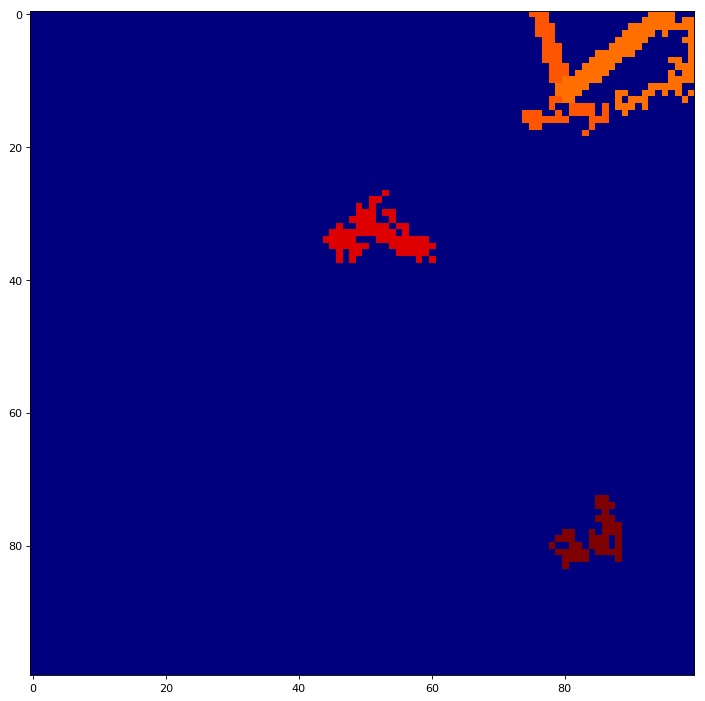

In [174]:
fig = plt.figure(figsize=(11, 11), dpi=80, facecolor='w', edgecolor='k')


pic = np.zeros(markers.shape)
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        if markers[i,j] in comp_map:
            pic[i,j] = markers[i,j]+3000
plt.imshow(pic[height_margin:height_margin + displayed_sq, width_margin:width_margin + displayed_sq], cmap="jet")

In [158]:
nucl_info, axons_info, markers = get_nucleus_and_axons_info(comp_map, markers)

25
126


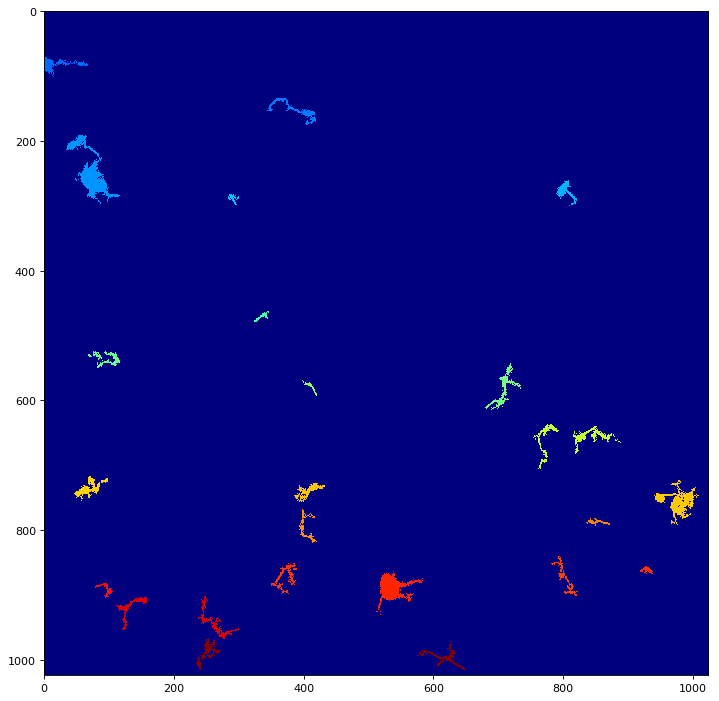

In [159]:
fig = plt.figure(figsize=(11, 11), dpi=80, facecolor='w', edgecolor='k')
pic = np.zeros(markers.shape)
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        if markers[i,j] in nucl_info:
            pic[i,j] = markers[i,j]+3000
plt.imshow(pic[height_margin:height_margin + displayed_sq, width_margin:width_margin + displayed_sq], cmap="jet")

25
296 0
586 0
937 0
1398 0
1624 0
3334 0
3946 2
4177 2
4502 1
5484 2
5560 0
6928 2
7041 1
7128 1
7917 0
8154 1
9148 0
9316 0
9456 0
9587 2
9900 0
10236 0
10238 0
11367 0
11452 0


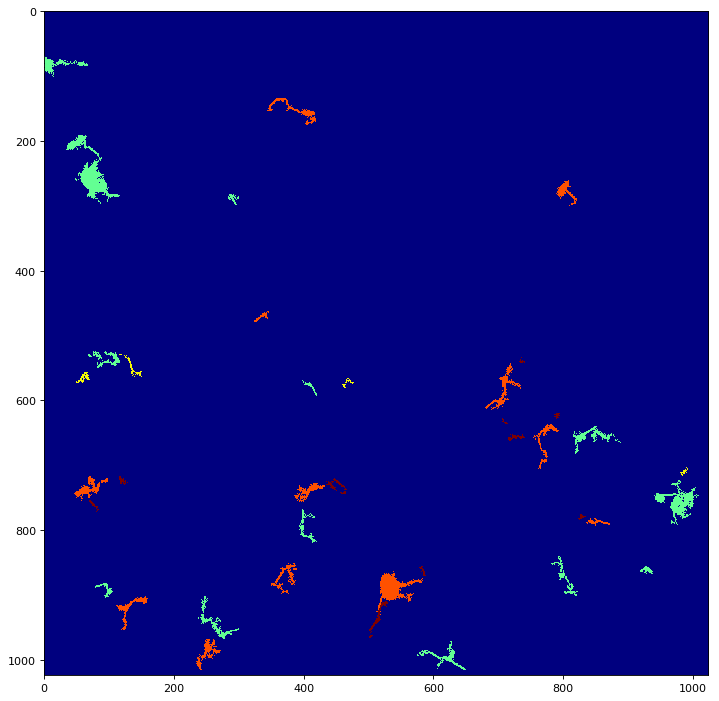

In [160]:
draw_components_with_nucl_map(markers, nucl_info)

In [ ]:
# to do
# Write function to compute distance between contours. 

# more ideas:
# search for axons form axons
# implement contour filtering of axons
# add intensity related features
# Check if two centroids is closely contcted and merge them if needed.